<a href="https://colab.research.google.com/github/aribamazharam/efficient-net/blob/main/Yoga_EfficientNet_b0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install efficientnet_pytorch
!pip install torch torchvision

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=e1a5c0e5e784aa16ad22be13d6eff1329b7e07900c142f29f1e373c61b2e4993
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [4]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from efficientnet_pytorch import EfficientNet

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
from torchvision import datasets, transforms
import torch

# Path to your data
data_dir = '/content/drive/MyDrive/data_augmented_split'  # Replace with your dataset directory
train_dir = os.path.join(data_dir, 'train')  # Assuming you have a train directory
val_dir = os.path.join(data_dir, 'valid')  # Assuming you have a validation directory

# Define transformations for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
val_data = datasets.ImageFolder(val_dir, transform=val_transforms)
test_data = datasets.ImageFolder(val_dir, transform=test_transforms)

# Create dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [7]:
num_classes = len(train_data.classes)  # Assuming each folder in your directory is a different class

# Load pre-trained model
model = EfficientNet.from_pretrained('efficientnet-b0')

# Adjust last layer to match number of classes
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, num_classes)

# Move to gpu and parallelize
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:01<00:00, 17.8MB/s]


Loaded pretrained weights for efficientnet-b0


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 12.0 MB/s eta 0:00:00


In [10]:
import os
from efficientnet_pytorch import EfficientNet
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model_name = 'efficientnet-b0'
num_classes = 107  # Replace '10' with the actual number of classes in your data.
model = EfficientNet.from_pretrained(model_name, num_classes=num_classes)
model = model.to(device)

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

EPOCHS = 10
best_val_loss = float('inf')  # initialize best validation loss

# Define checkpoint path
checkpoint_path = '/content/drive/MyDrive/data_augmented_split/model_checkpoints/model.pt'

# Create the directory if it does not exist
checkpoint_directory = os.path.dirname(checkpoint_path)
if not os.path.exists(checkpoint_directory):
    os.makedirs(checkpoint_directory)

# Check if checkpoint file exists
if os.path.exists(checkpoint_path):
    # Load checkpoint if it exists
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_val_loss = checkpoint['best_val_loss']
    print("Checkpoint loaded successfully.")
else:
    print("Checkpoint not found. Training from scratch.")


# Initialize the history dictionary
history = {
    "train_loss": [],
    "train_acc": [],
    "train_prec": [],
    "train_recall": [],
    "val_loss": [],
    "val_acc": [],
    "val_prec": [],
    "val_recall": [],
}

# Training loop
model.train()
for epoch in range(EPOCHS):
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Add batch predictions and labels to lists
        all_preds += preds.detach().cpu().numpy().tolist()
        all_labels += labels.detach().cpu().numpy().tolist()

    # Compute validation loss and metrics
    val_loss = 0.0
    val_all_preds = []
    val_all_labels = []
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            # Add batch predictions and labels to lists
            val_all_preds += preds.detach().cpu().numpy().tolist()
            val_all_labels += labels.detach().cpu().numpy().tolist()

    model.train()  # set model back to training mode
    epoch_loss = running_loss / len(trainloader.dataset)
    val_loss = val_loss / len(valloader.dataset)

    # Save model if validation loss has decreased
    if val_loss <= best_val_loss:
        print(f'Validation loss decreased ({best_val_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss
        }, checkpoint_path)
        best_val_loss = val_loss

    # Calculate and print metrics
    train_acc = accuracy_score(all_labels, all_preds)
    train_prec = precision_score(all_labels, all_preds, average='macro')
    train_recall = recall_score(all_labels, all_preds, average='macro')
    val_acc = accuracy_score(val_all_labels, val_all_preds)
    val_prec = precision_score(val_all_labels, val_all_preds, average='macro')
    val_recall = recall_score(val_all_labels, val_all_preds, average='macro')

    # Append metrics to the history
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(train_acc)
    history['train_prec'].append(train_prec)
    history['train_recall'].append(train_recall)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_prec'].append(val_prec)
    history['val_recall'].append(val_recall)

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print(f'Training Loss: {epoch_loss:.4f}, Accuracy: {train_acc:.4f}, Precision: {train_prec:.4f}, Recall: {train_recall:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_recall:.4f}\n')


Loaded pretrained weights for efficientnet-b0
Checkpoint loaded successfully.


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (0.507515 --> 0.506070).  Saving model ...
Epoch 1/10
Training Loss: 0.8299, Accuracy: 0.7783, Precision: 0.7839, Recall: 0.7694
Validation Loss: 0.5061, Accuracy: 0.8460, Precision: 0.8610, Recall: 0.8433



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (0.506070 --> 0.488403).  Saving model ...
Epoch 2/10
Training Loss: 0.8191, Accuracy: 0.7820, Precision: 0.7840, Recall: 0.7712
Validation Loss: 0.4884, Accuracy: 0.8531, Precision: 0.8613, Recall: 0.8508



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3/10
Training Loss: 0.8323, Accuracy: 0.7821, Precision: 0.7879, Recall: 0.7714
Validation Loss: 0.4893, Accuracy: 0.8540, Precision: 0.8635, Recall: 0.8493



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (0.488403 --> 0.484089).  Saving model ...
Epoch 4/10
Training Loss: 0.8290, Accuracy: 0.7768, Precision: 0.7795, Recall: 0.7653
Validation Loss: 0.4841, Accuracy: 0.8522, Precision: 0.8626, Recall: 0.8502



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (0.484089 --> 0.483452).  Saving model ...
Epoch 5/10
Training Loss: 0.8037, Accuracy: 0.7891, Precision: 0.7952, Recall: 0.7813
Validation Loss: 0.4835, Accuracy: 0.8619, Precision: 0.8755, Recall: 0.8580



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 6/10
Training Loss: 0.8063, Accuracy: 0.7855, Precision: 0.7882, Recall: 0.7759
Validation Loss: 0.4864, Accuracy: 0.8549, Precision: 0.8680, Recall: 0.8515



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 7/10
Training Loss: 0.7982, Accuracy: 0.7876, Precision: 0.7903, Recall: 0.7782
Validation Loss: 0.4974, Accuracy: 0.8540, Precision: 0.8668, Recall: 0.8489



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (0.483452 --> 0.479761).  Saving model ...
Epoch 8/10
Training Loss: 0.8037, Accuracy: 0.7870, Precision: 0.7920, Recall: 0.7771
Validation Loss: 0.4798, Accuracy: 0.8549, Precision: 0.8677, Recall: 0.8530



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (0.479761 --> 0.479593).  Saving model ...
Epoch 9/10
Training Loss: 0.8048, Accuracy: 0.7879, Precision: 0.7945, Recall: 0.7792
Validation Loss: 0.4796, Accuracy: 0.8558, Precision: 0.8710, Recall: 0.8507



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 10/10
Training Loss: 0.7911, Accuracy: 0.7881, Precision: 0.7897, Recall: 0.7785
Validation Loss: 0.4858, Accuracy: 0.8566, Precision: 0.8725, Recall: 0.8528



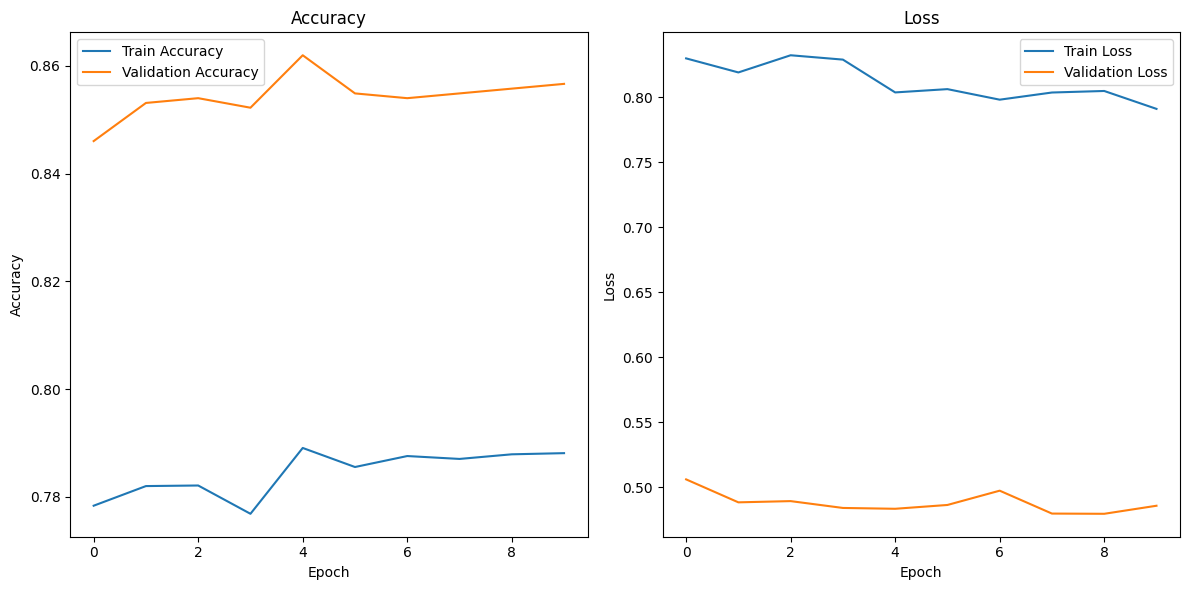

In [12]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()